# Analyzing Catalogs Subject to Selection Effects

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import aesara.tensor as at
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.special as sp
import scipy.stats as ss
import seaborn as sns
import xarray as xr

sns.set_context('notebook')
sns.set_palette('husl')

## Inhomogeneous Poisson Likelihood

...some boardwork deriving the IPL:
$$
p\left( x \mid \lambda \right) = \exp\left( - N\left( \lambda \right) \right) \prod_{i=1}^{N_\mathrm{obs}} \frac{\mathrm{d}N}{\mathrm{d} x_i}\left( \lambda \right)
$$
.  Eventually talking about Schechter luminosity function:
$$
\frac{\mathrm{d} N}{\mathrm{d} \log L \mathrm{d} V} = L \frac{\mathrm{d} N}{\mathrm{d} L \mathrm{d} V} = n \left( \frac{L}{L_*} \right)^\alpha \exp\left( -\frac{L}{L_*} \right).
$$
Statisticians call part of this the gamma distribution with shape parameter $\alpha$ and scale parameter $L_*$.  Our "population parameters" are $\lambda = \left\{ n, \alpha, L_* \right\}$.  Note: $n$ is the density per log luminosity per volume of objects with luminosity $L = L_*$.  As long as $\alpha > 0$, the total number of objects is finite over all luminosities.

In a volume $V$, there will be 
$$
N = \int \mathrm{d} \log L \, \mathrm{d} V \, \frac{\mathrm{d} N}{\mathrm{d} \log L \mathrm{d} V} = \Gamma(\alpha) n V
$$
objects from this distribution.  We will draw a sample from this luminosity function 

In [3]:
n_true = 100.0
alpha_true = 0.5
LStar_true = 1.0
V = 4/3*np.pi # Sphere of radius 1

N_true = np.random.poisson(n_true*sp.gamma(alpha_true)*V)
L = np.random.gamma(shape=alpha_true, scale=LStar_true, size=N_true)

def dNdlogL(xs, V, n, alpha, LStar):
    return np.log(10)*n*sp.gamma(alpha)*ss.gamma(alpha, scale=LStar).pdf(xs)*xs

Plot the data:

Text(7.569444444444452, 0.5, '$\\mathrm{d}N/\\mathrm{d} \\log L$')

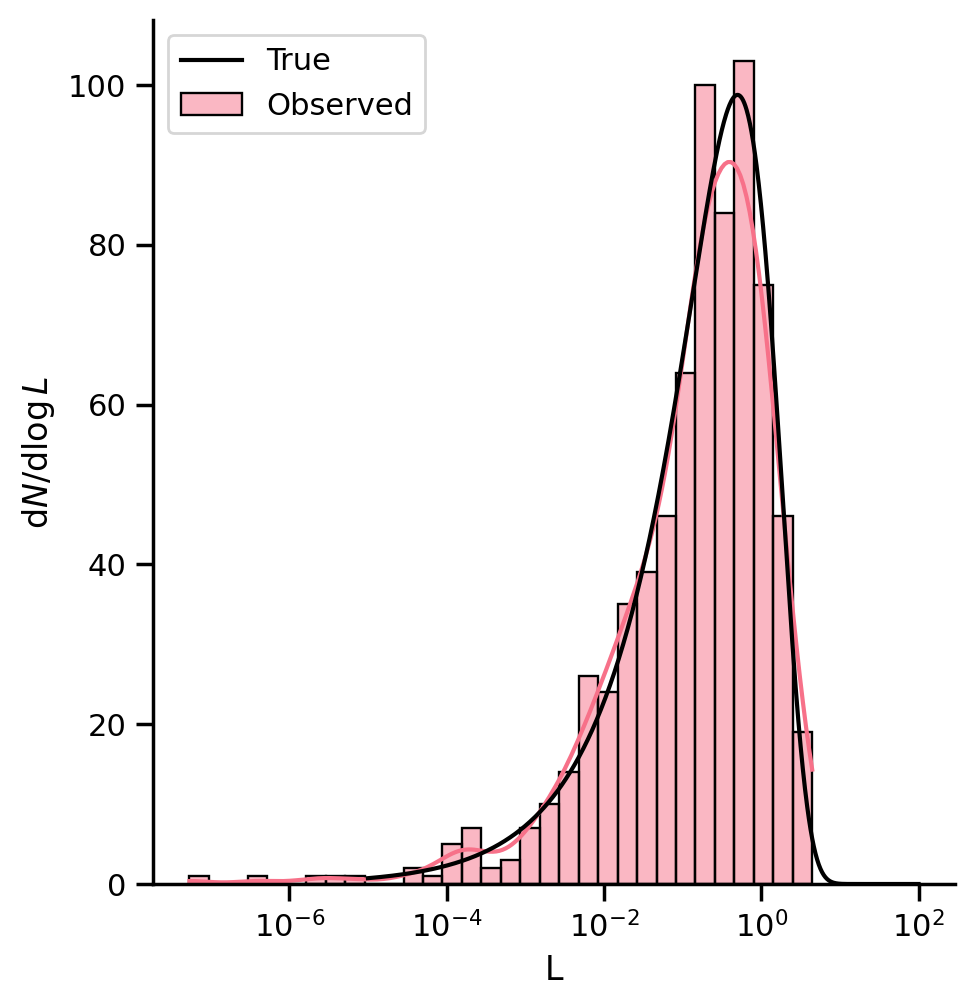

In [4]:
sns.displot(L, log_scale=True, label='Observed', kde=True)
xs = np.logspace(-5, 2, 1000)
plt.plot(xs, dNdlogL(xs, V, n_true, alpha_true, LStar_true), color='k', label='True')
plt.legend()
plt.xlabel(r"L")
plt.ylabel(r"$\mathrm{d}N/\mathrm{d} \log L$")

And now we build a pymc model to fit the data (we could have used `pm.Gamma` and remembered to put back in the right normalization, but instead we hand-coded the log-likelihood):

In [21]:
def make_Lf_model(L, V):
    with pm.Model() as model:
        n = pm.LogNormal('n', mu=np.log(10), sigma=1)
        alpha = pm.HalfNormal('alpha', sigma=1)
        LStar = pm.LogNormal('LStar', mu=np.log(1), sigma=1)

        _ = pm.Potential('likelihood', at.sum(at.log(n) + (alpha-1)*at.log(L) - alpha*at.log(LStar) - L/LStar) - n*V*at.gamma(alpha))
    return model

In [22]:
with make_Lf_model(L, V) as Lf_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [n, alpha, LStar]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.


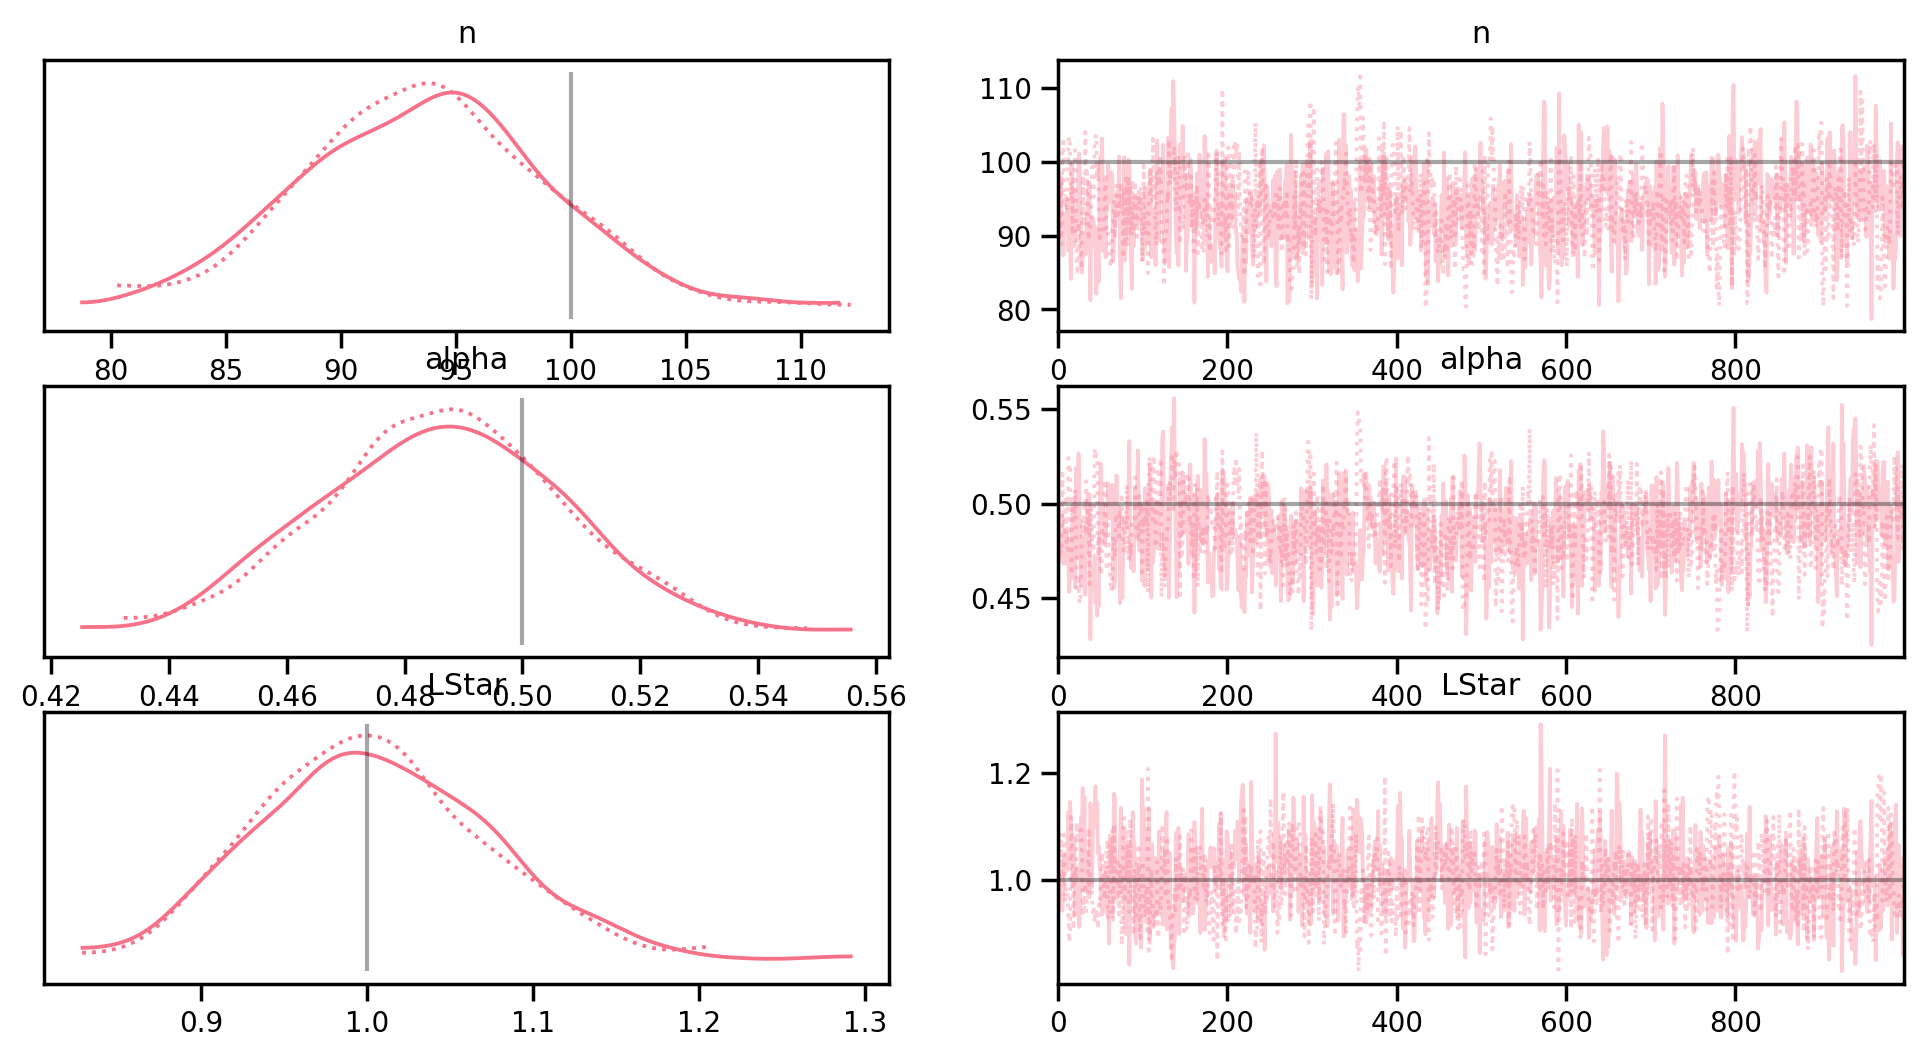

In [23]:
with Lf_model:
    az.plot_trace(trace, lines=[('n', {}, n_true), ('alpha', {}, alpha_true), ('LStar', {}, LStar_true)])

Let's look at the distribution we infer:

Text(7.569444444444452, 0.5, '$\\mathrm{d} N/\\mathrm{d} \\log L$')

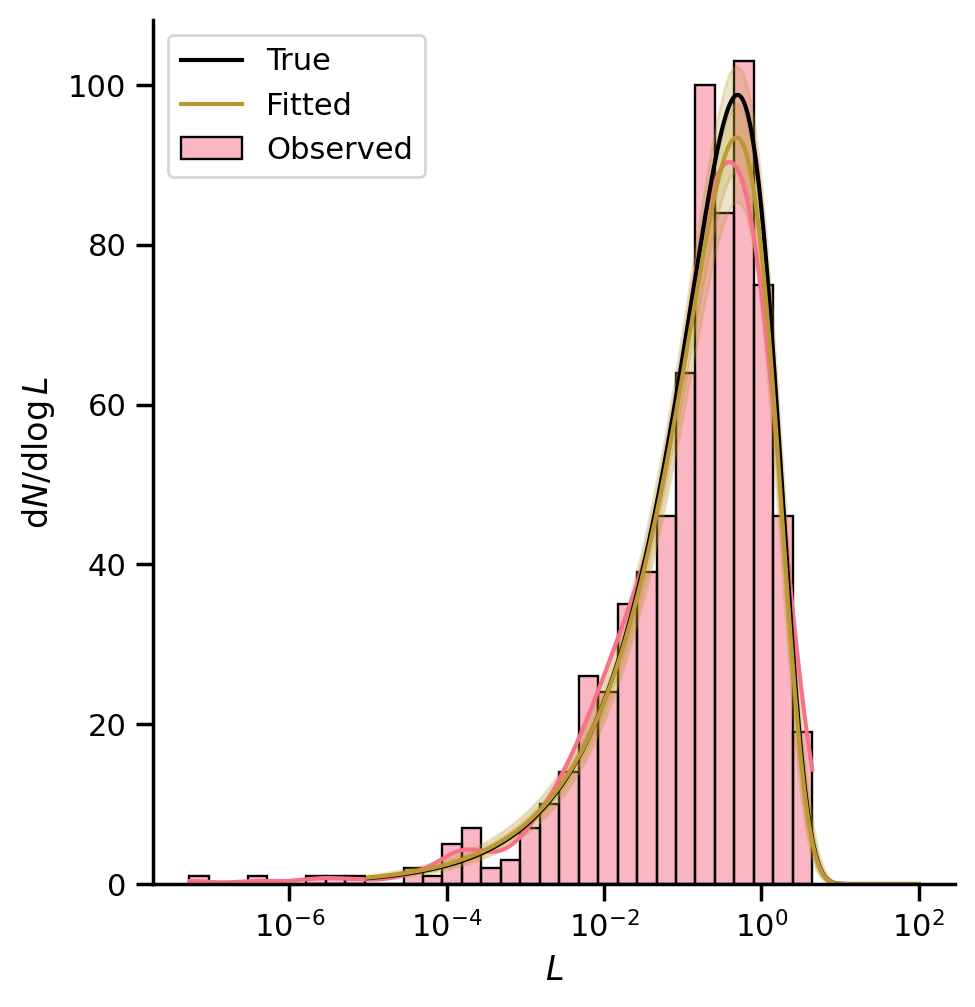

In [8]:
xs = np.logspace(-5,2,1000)
dN = []
for n, a, LS in zip(trace.posterior.n.values.flatten(), trace.posterior.alpha.values.flatten(), trace.posterior.LStar.values.flatten()):
    dN.append(dNdlogL(xs, V, n, a, LS))
dN = np.array(dN)

sns.displot(L, log_scale=True, label='Observed', kde=True)
plt.plot(xs, dNdlogL(xs, V, n_true, alpha_true, LStar_true), color='k', label='True')
l, = plt.plot(xs, np.mean(dN, axis=0), label='Fitted', color=sns.color_palette()[1])
plt.fill_between(xs, np.quantile(dN, 0.84, axis=0), np.quantile(dN, 0.16, axis=0), color=l.get_color(), alpha=0.25)
plt.fill_between(xs, np.quantile(dN, 0.975, axis=0), np.quantile(dN, 0.025, axis=0), color=l.get_color(), alpha=0.25)

plt.legend()
plt.xlabel(r'$L$')
plt.ylabel(r'$\mathrm{d} N/\mathrm{d} \log L$')

## Observational Uncertanties

Now let's add uncertainty to the observations: we observe a luminosity that is related to the true luminosity with a log-normal distribution with known $\sigma = 0.1$:
$$
p\left( L_\mathrm{obs} \mid L \right) = \frac{1}{\sqrt{2\pi} \sigma L_\mathrm{obs}} \exp\left( - \frac{\left( \log L_\mathrm{obs} - \log L \right)^2}{2 \sigma^2} \right);
$$
we now need to add parameters for each (latent, un-observed) true luminosity, but otherwise the model looks pretty much the same; the log-likelihood has become a product of the Poisson term for the true luminosity and the above density connecting the true and observed luminosities.
$$
p\left( L_\mathrm{obs} \mid L, \lambda \right) = \exp\left( - N\left( \lambda \right) \right) \prod_{i=1}^{N_\mathrm{obs}} \frac{\mathrm{d}N}{\mathrm{d} L_i \mathrm{d} V}\left( \lambda \right) p\left( L_\mathrm{obs,i} \mid L_i \right)
$$

In [9]:
sigma_true = 0.25
Lobs = np.random.lognormal(mean=np.log(L), sigma=sigma_true)

Text(7.569444444444452, 0.5, '$\\mathrm{d}N/\\mathrm{d} \\log L$')

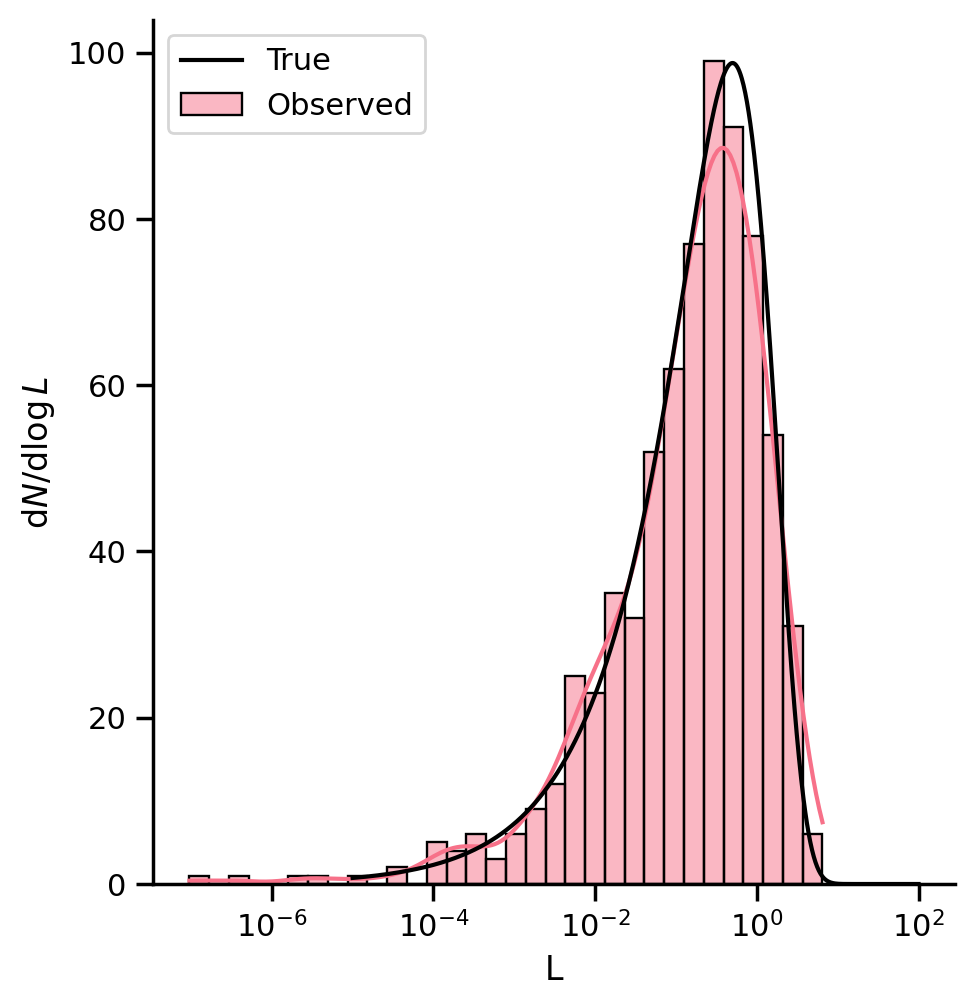

In [10]:
sns.displot(Lobs, log_scale=True, label='Observed', kde=True)
xs = np.logspace(-5, 2, 1000)
plt.plot(xs, dNdlogL(xs, V, n_true, alpha_true, LStar_true), color='k', label='True')
plt.legend()
plt.xlabel(r"L")
plt.ylabel(r"$\mathrm{d}N/\mathrm{d} \log L$")

When we define the model, we impose a uniform prior on $L \in [0, 100]$; eventually we will apply the "population" distribution $\mathrm{d}N/\mathrm{d} \log L \mathrm{d} V$ using the `Potential` call, and the uniform distribution is a constant, and therefore ignorable, density.

In [24]:
def make_Lf_err_model(Lobs, V, sigma_obs):
    N = Lobs.shape[0]
    with pm.Model() as model:
        n = pm.LogNormal('n', mu=np.log(10), sigma=1)
        alpha = pm.HalfNormal('alpha', sigma=1)
        LStar = pm.LogNormal('LStar', mu=np.log(1), sigma=1)
        L = pm.Uniform('L', lower=0, upper=100, shape=(N,), initval=Lobs)

        _ = pm.Potential('poisson-likelihood', at.sum(at.log(n) + (alpha-1)*at.log(L) - alpha*at.log(LStar) - L/LStar) - n*V*at.gamma(alpha))
        _ = pm.Lognormal('observation-likelihood', mu=np.log(L), sigma=sigma_obs, observed=Lobs)
    return model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [n, alpha, LStar, L]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.


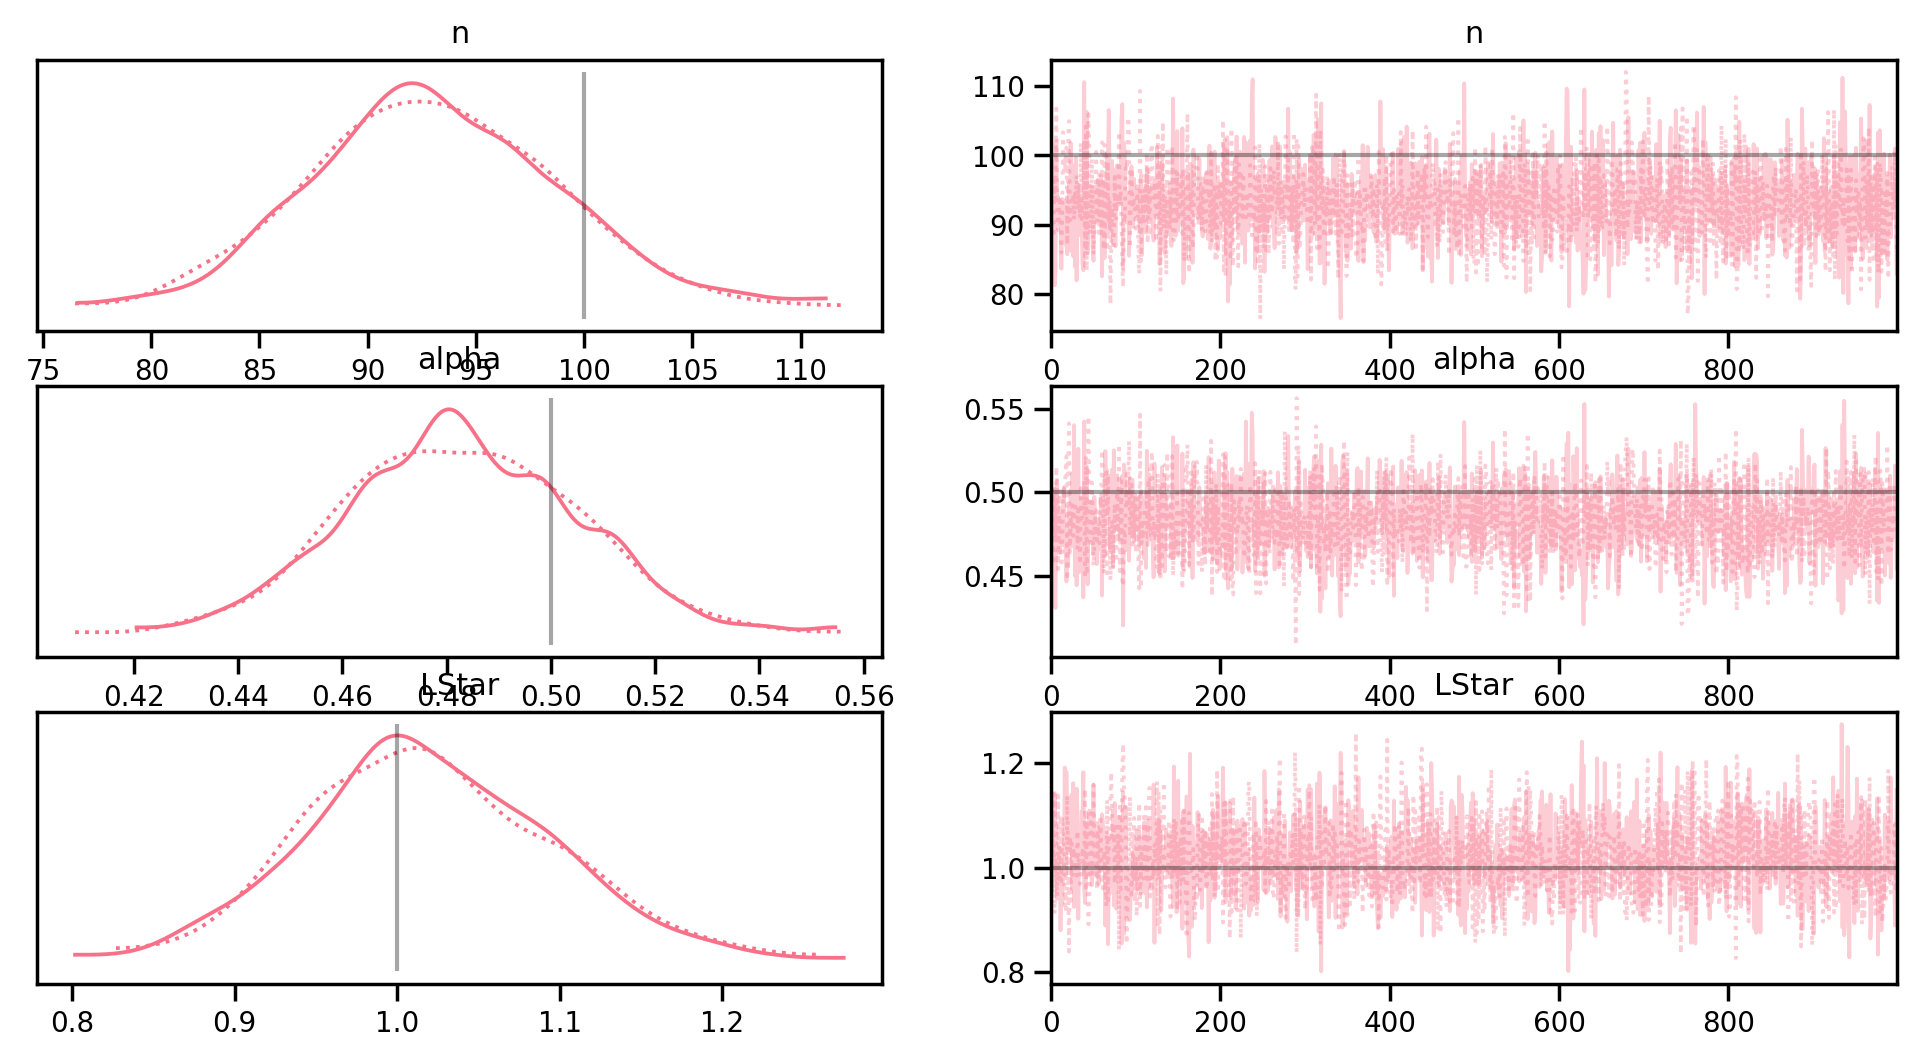

In [25]:
with make_Lf_err_model(Lobs, V, sigma_true) as Lf_err_model:
    trace = pm.sample()
    az.plot_trace(trace, var_names=['n', 'alpha', 'LStar'], lines=[('n', {}, n_true), ('alpha', {}, alpha_true), ('LStar', {}, LStar_true)])

Text(7.569444444444452, 0.5, '$\\mathrm{d} N/\\mathrm{d} \\log L$')

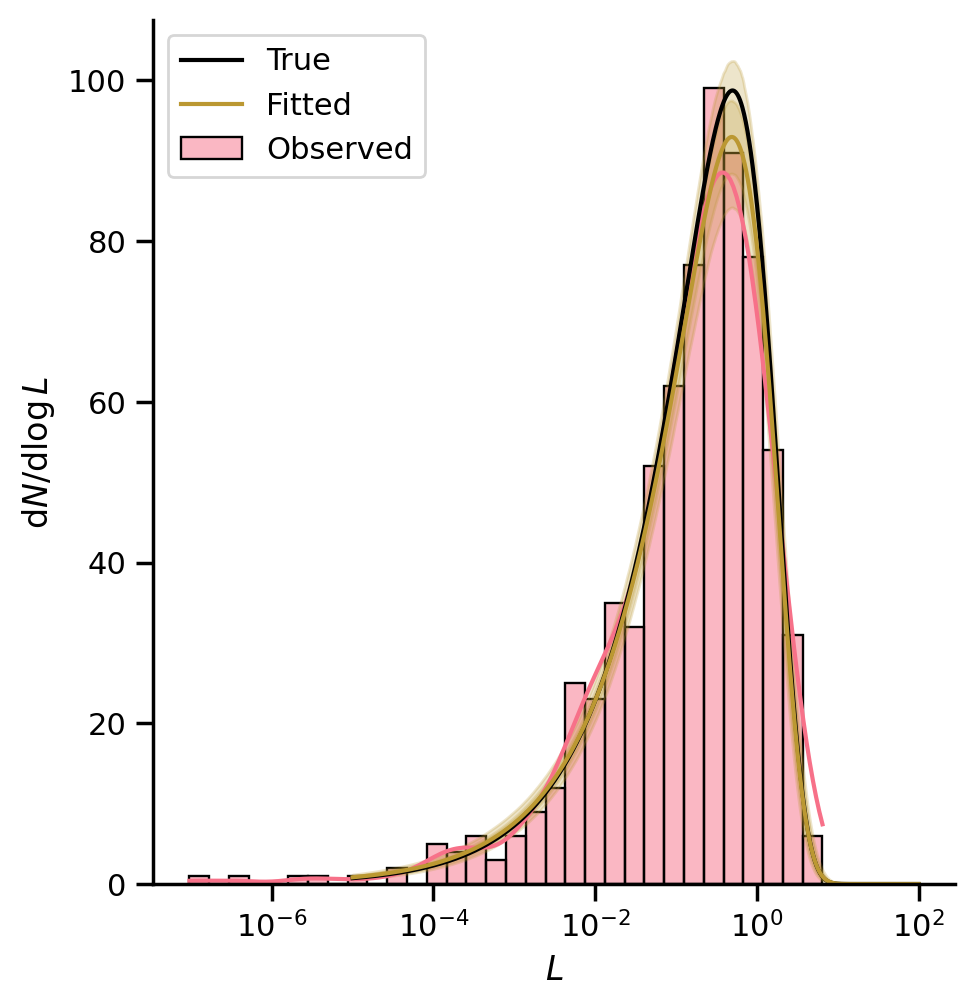

In [26]:
xs = np.logspace(-5,2,1000)
dN = []
for n, a, LS in zip(trace.posterior.n.values.flatten(), trace.posterior.alpha.values.flatten(), trace.posterior.LStar.values.flatten()):
    dN.append(dNdlogL(xs, V, n, a, LS))
dN = np.array(dN)

sns.displot(Lobs, log_scale=True, label='Observed', kde=True)
plt.plot(xs, dNdlogL(xs, V, n_true, alpha_true, LStar_true), color='k', label='True')
l, = plt.plot(xs, np.mean(dN, axis=0), label='Fitted', color=sns.color_palette()[1])
plt.fill_between(xs, np.quantile(dN, 0.84, axis=0), np.quantile(dN, 0.16, axis=0), color=l.get_color(), alpha=0.25)
plt.fill_between(xs, np.quantile(dN, 0.975, axis=0), np.quantile(dN, 0.025, axis=0), color=l.get_color(), alpha=0.25)

plt.legend()
plt.xlabel(r'$L$')
plt.ylabel(r'$\mathrm{d} N/\mathrm{d} \log L$')

## Observational Uncertainties Plus Selection Function

...boardwork to get to the *selected* IHP likelihood:
$$
p\left( x_\mathrm{obs} \mid x, \lambda \right) = \exp\left( -N_\mathrm{det}\left( \lambda \right) \right) \prod_{i=1}^{N_\mathrm{obs}} p\left( x_{\mathrm{obs},i} \mid x_i \right) \frac{\mathrm{d} N}{\mathrm{d} x_i} \left( \lambda \right),
$$
where 
$$
N_\mathrm{det}\left( \lambda \right) = \int \mathrm{d} x \, P_\mathrm{det}(x) \frac{\mathrm{d} N}{\mathrm{d} x} = \int_{f\left( x_\mathrm{obs} \right)>0} \mathrm{d} x_\mathrm{obs} \, \mathrm{d} x \, p\left( x_\mathrm{obs} \mid x \right) \frac{\mathrm{d} N}{\mathrm{d} x}.
$$

We have to evaluate the $N_\mathrm{det}$ integral, and it's not in general possible to do analytically.  But it is possible to do with injections: we will generate signals from a distribution $p_\mathrm{draw} \left( x \right)$, put them through our instrument (or a model of it), and record which ones get detected and their parameters.  Then the integral above is 
$$
N_\mathrm{det}\left( \lambda \right) = \int_{f\left( x_\mathrm{obs} \right)>0} \mathrm{d} x_\mathrm{obs} \, \mathrm{d} x \, p\left( x_\mathrm{obs} \mid x \right) \frac{\mathrm{d} N}{\mathrm{d} x} = \frac{1}{N_\mathrm{draw}} \sum_{i = 1}^{N_\mathrm{draw}} \frac{\mathbb{I}\left(x_i \in \mathrm{det} \right)}{p_\mathrm{draw}\left( x_i \right)} \frac{\mathrm{d} N}{\mathrm{d} x_i} = \frac{1}{N_\mathrm{draw}} \sum_{j = 1}^{N_\mathrm{det}} \frac{1}{p_\mathrm{draw}\left( x_j \right)} \frac{\mathrm{d} N}{\mathrm{d} x_j}
$$

[Farr (2019)](https://ui.adsabs.harvard.edu/abs/2019RNAAS...3...66F/abstract) gave formulas for the necessary accuracy to which the above Monte-Carlo integral must be evaluated.  The upshot is that we will need a constant factor more detected injections than catalog entries.  

In our concrete example, we assume that there is some flux limit to our survey; if $L_\mathrm{obs} / 4 \pi d^2 < F_\mathrm{thresh}$ then the object is not recorded in the catalog.  We have chosen our flux limit so that we are complete (in expectation!) for $L_*$ objects out to our maximum distance.  

In [14]:
DMax = np.cbrt(V/(4/3*np.pi))
F_thresh = LStar_true / (4*np.pi*DMax*DMax) # We are complete for LStar objects.

# Uniform in volume
ds = DMax*np.cbrt(np.random.uniform(low=0,high=1,size=len(Lobs)))

Fobs = Lobs / (4*np.pi*ds*ds)
detected_mask = Fobs > F_thresh
print('from {} objects, I detect {}'.format(len(Lobs), np.sum(detected_mask)))

from 717 objects, I detect 207


You can see that there is a sharp boundary between detected and non-detected objects in their *observed* properties (we always choose catalogs based on their *observed* properties; we don't have access to the latent, un-observed true parameters of our objects!).

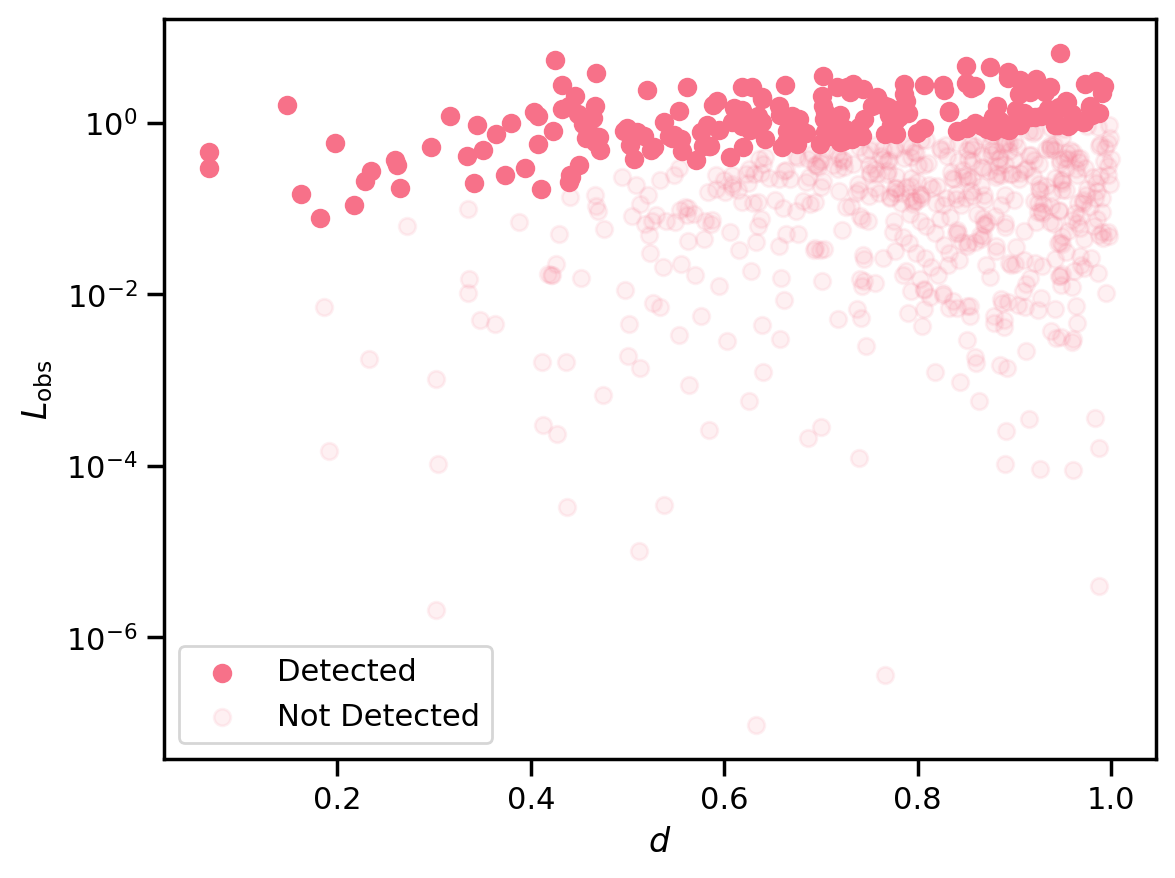

In [15]:
plt.scatter(ds[detected_mask], Lobs[detected_mask], label='Detected')
plt.scatter(ds[~detected_mask], Lobs[~detected_mask], alpha=0.1, color=sns.color_palette()[0], label='Not Detected')
plt.yscale('log')
plt.ylabel(r'$L_\mathrm{obs}$')
plt.xlabel(r'$d$')
plt.legend()

Here is the same thing with the true luminosity.  We can see that the boundary is not sharp:

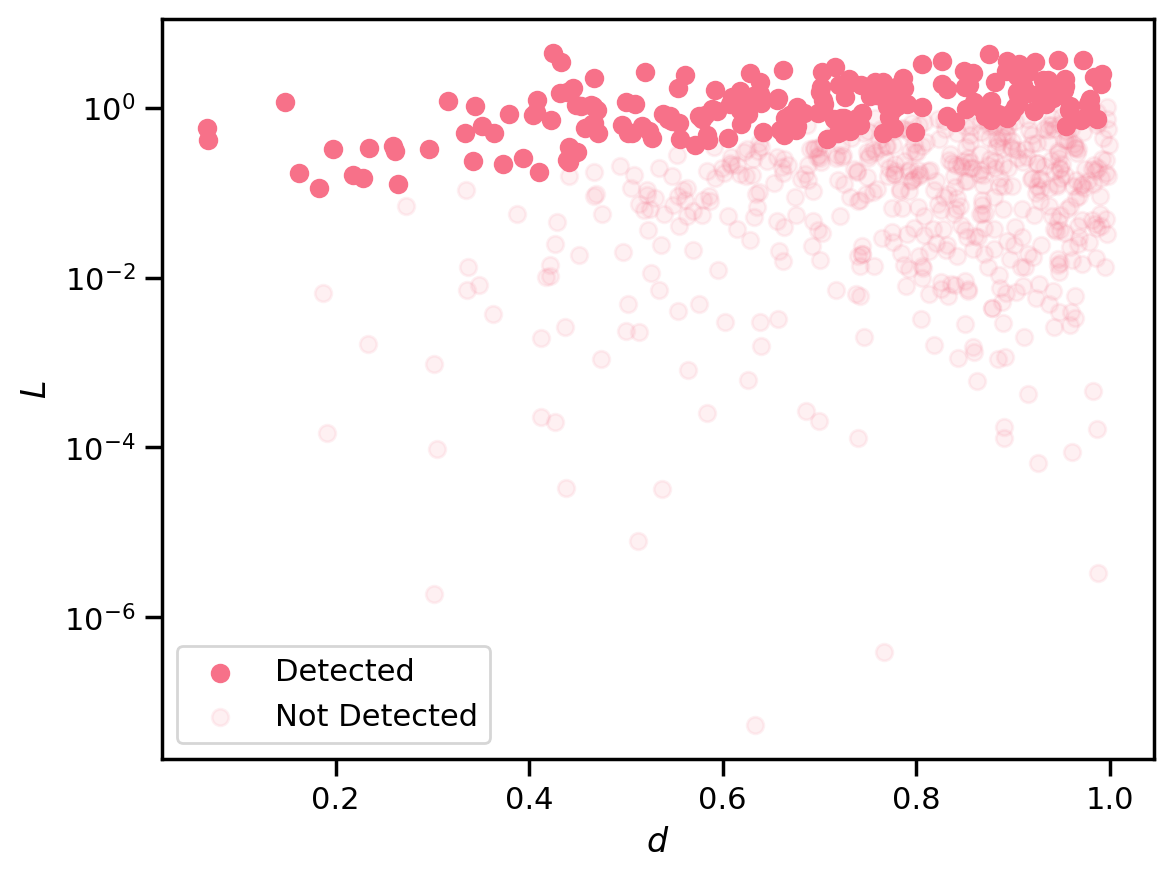

In [16]:
plt.scatter(ds[detected_mask], L[detected_mask], label='Detected')
plt.scatter(ds[~detected_mask], L[~detected_mask], alpha=0.1, color=sns.color_palette()[0], label='Not Detected')
plt.yscale('log')
plt.ylabel(r'$L$')
plt.xlabel(r'$d$')
plt.legend()

Let's generate injections.  We draw $L$ from the true distribution (this will be a good match to our fit, and so our importance weights will be better-behaved; in general, we don't have access to the *true* distribution, but we do have an idea of the types of shapes that our fit is going to return, and so can optimize the injections a bit); we draw $d$ from the true distribution.  Note that the draw density is normalized to integrate to 1 over the entire domain (lacking normalization here will not change the fitted *shape*, but will make the fitted *normalization* $n$ incorrect).

In [17]:
Ndraw = 10000
Ldraw = np.random.gamma(shape=alpha_true, scale=LStar_true, size=Ndraw)
Ldraw_obs = np.random.lognormal(mean=np.log(Ldraw), sigma=sigma_true)
ddraw = DMax*np.cbrt(np.random.uniform(low=0,high=1,size=Ndraw))
Fdraw = Ldraw/(4*np.pi*ddraw*ddraw)
pdraw = ss.gamma(alpha_true, scale=LStar_true).pdf(Ldraw) / V # Note density in L and V
draw_detected_mask = Fdraw > F_thresh
np.sum(draw_detected_mask)

3050

Building the model; see [Farr (2019)](https://ui.adsabs.harvard.edu/abs/2019RNAAS...3...66F/abstract) for derivation of the uncertainty and the `Neff` parameter that described the variance of the Monte-Carlo estimate of $N_\mathrm{det}$.  As long as $N_\mathrm{eff} \gg 4 N_\mathrm{obs}$ the estimate should be sufficiently accurate to trust our inference; we will check this later.  (See also [Essick & Farr (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220400461E/abstract) for better error estimates, and discussion.)

In [18]:
def log_dNdLdV(L, n, alpha, LStar):
    return at.log(n) + (alpha-1)*at.log(L) - alpha*at.log(LStar) - L/LStar

def make_Lf_err_selected_model(Lobs, V, sigma_obs, Ldraw, pdraw, Ndraw):
    N = Lobs.shape[0]
    log_pdraw = np.log(pdraw)
    with pm.Model() as model:
        n = pm.LogNormal('n', mu=np.log(10), sigma=1)
        alpha = pm.HalfNormal('alpha', sigma=1)
        LStar = pm.LogNormal('LStar', mu=np.log(1), sigma=1)
        L = pm.Uniform('L', lower=0, upper=100, shape=(N,), initval=Lobs)

        _ = pm.Potential('poisson-likelihood', at.sum(log_dNdLdV(L, n, alpha, LStar)))
        _ = pm.Lognormal('observation-likelihood', mu=np.log(L), sigma=sigma_obs, observed=Lobs)

        log_Ndet_wt = log_dNdLdV(Ldraw, n, alpha, LStar) - log_pdraw
        log_Ndet_wt2 = 2*log_Ndet_wt

        Ndet = at.exp(at.logsumexp(log_Ndet_wt) - at.log(Ndraw))
        _ = pm.Potential('normalization', -Ndet)

        s2 = at.exp(at.logsumexp(log_Ndet_wt2))/(Ndraw*Ndraw) - Ndet*Ndet/Ndraw
        Neff = pm.Deterministic('Neff', Ndet*Ndet/s2)
    return model

We see that our fit indeed gives $N_\mathrm{eff} \gg 4 N_\mathrm{obs}$, and that the fitted population parameters are on-track:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [n, alpha, LStar, L]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


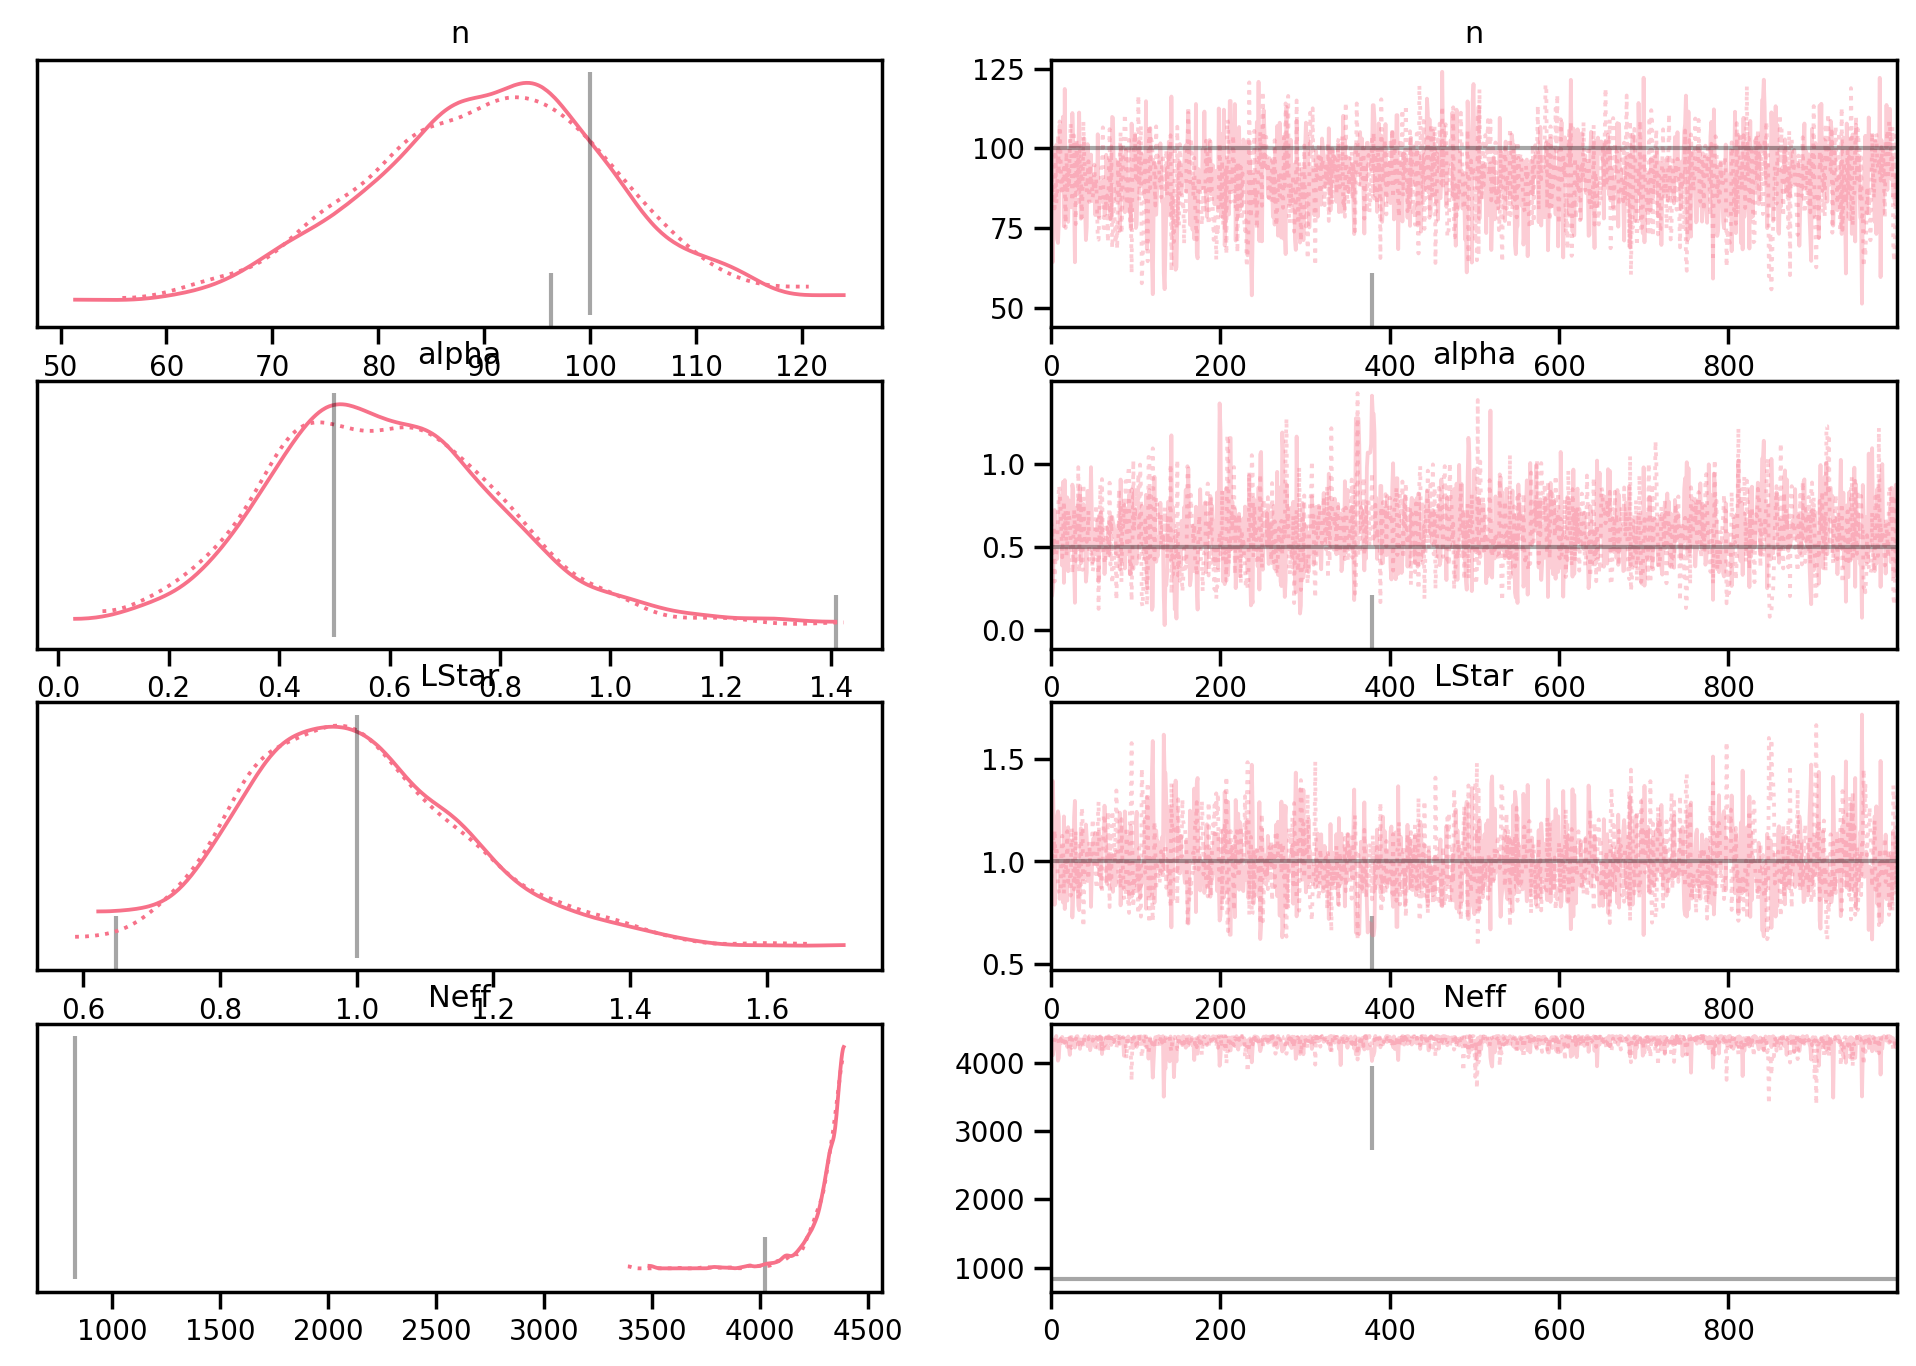

In [19]:
with make_Lf_err_selected_model(Lobs[detected_mask], V, sigma_true, Ldraw[draw_detected_mask], pdraw[draw_detected_mask], Ndraw) as Lf_err_selected_model:
    trace = pm.sample()
    az.plot_trace(trace, var_names=['n', 'alpha', 'LStar', 'Neff'], lines=[('n', {}, n_true), ('alpha', {}, alpha_true), ('LStar', {}, LStar_true), ('Neff', {}, 4*np.sum(detected_mask))])

Here, even though the observed distribution is quite different from truth, we properly recover the true distribution (with larger uncertainty, corresponding to our down-selected data set).

Text(17.31944444444445, 0.5, '$\\mathrm{d} N/\\mathrm{d} \\log L$')

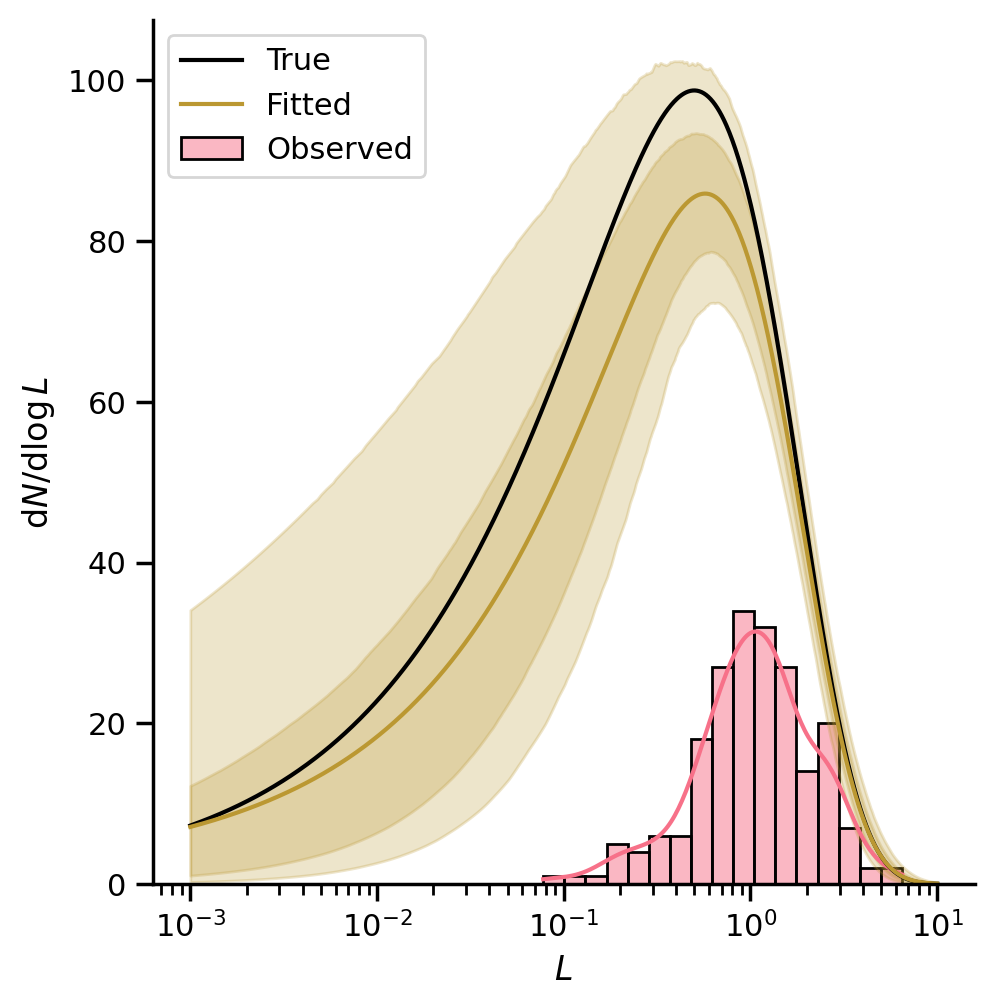

In [20]:
xs = np.logspace(-3,1,1000)
dN = []
for n, a, LS in zip(trace.posterior.n.values.flatten(), trace.posterior.alpha.values.flatten(), trace.posterior.LStar.values.flatten()):
    dN.append(dNdlogL(xs, V, n, a, LS))
dN = np.array(dN)

sns.displot(Lobs[detected_mask], log_scale=True, label='Observed', kde=True)
plt.plot(xs, dNdlogL(xs, V, n_true, alpha_true, LStar_true), color='k', label='True')
l, = plt.plot(xs, np.mean(dN, axis=0), label='Fitted', color=sns.color_palette()[1])
plt.fill_between(xs, np.quantile(dN, 0.84, axis=0), np.quantile(dN, 0.16, axis=0), color=l.get_color(), alpha=0.25)
plt.fill_between(xs, np.quantile(dN, 0.975, axis=0), np.quantile(dN, 0.025, axis=0), color=l.get_color(), alpha=0.25)

plt.legend()
plt.xlabel(r'$L$')
plt.ylabel(r'$\mathrm{d} N/\mathrm{d} \log L$')